In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Load image data
def load_leukemia_images(root_path, img_size=64):
    X, y = [], []
    label_map = {}
    label_counter = 0
    for fold in sorted(os.listdir(root_path)):
        fold_path = os.path.join(root_path, fold)
        if not os.path.isdir(fold_path): continue
        for label in sorted(os.listdir(fold_path)):
            label_path = os.path.join(fold_path, label)
            if not os.path.isdir(label_path): continue
            if label not in label_map:
                label_map[label] = label_counter
                label_counter += 1
            for fname in os.listdir(label_path):
                if fname.lower().endswith(".bmp"):
                    fpath = os.path.join(label_path, fname)
                    img = cv2.imread(fpath)
                    if img is not None:
                        img = cv2.resize(img, (img_size, img_size))
                        X.append(img.flatten())
                        y.append(label_map[label])
    return np.array(X), np.array(y), label_map

root_path = "/Users/apple/Desktop/WAMM/Leukemia/training_data"
X, y, label_map = load_leukemia_images(root_path)
labels = np.array(list(label_map.keys()))
colors = ['darkblue', 'darkgreen', 'darkred'][:len(labels)]

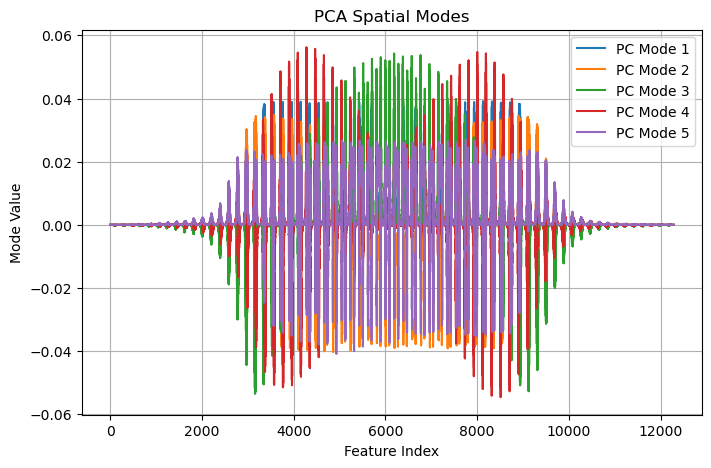

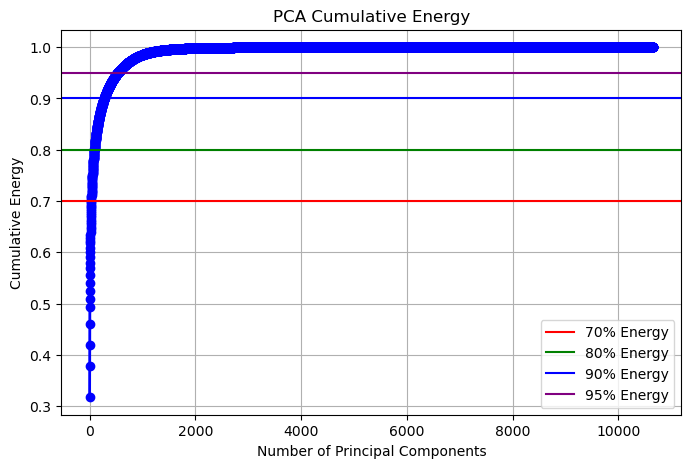

In [29]:
# Step 2: PCA analysis
pca = PCA()
X_pca = pca.fit_transform(X)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
for i in range(5):
    plt.plot(pca.components_[i], label=f'PC Mode {i+1}')
plt.xlabel("Feature Index")
plt.ylabel("Mode Value")
plt.title("PCA Spatial Modes")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance_ratio)+1), explained_variance_ratio, 'bo-', linewidth=2)
for level, color in zip([0.7, 0.8, 0.9, 0.95], ['r', 'g', 'b', 'purple']):
    plt.axhline(y=level, color=color, linestyle='-', label=f'{int(level*100)}% Energy')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Energy')
plt.title('PCA Cumulative Energy')
plt.legend()
plt.grid()
plt.show()

In [31]:
# Step 3: Classification using centroids
k_values = [1, 2, 3, 4, 5, 6, 7]
accuracy_results = []

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

for k in k_values:
    X_k = X_train_pca[:, :k]
    centroids = {
        class_label: np.mean(X_k[y_train == class_label], axis=0)
        for class_label in np.unique(y_train)
    }

    test_proj = X_test_pca[:, :k]
    predicted_labels = []
    for x in test_proj:
        distances = {label: np.linalg.norm(x - centroid) for label, centroid in centroids.items()}
        predicted_labels.append(min(distances, key=distances.get))
    acc = accuracy_score(y_test, predicted_labels)
    accuracy_results.append(acc * 100)
    print(f"k={k}, Accuracy = {acc * 100:.2f}%")

k=1, Accuracy = 75.39%
k=2, Accuracy = 76.18%
k=3, Accuracy = 76.18%
k=4, Accuracy = 76.14%
k=5, Accuracy = 76.18%
k=6, Accuracy = 76.23%
k=7, Accuracy = 76.09%


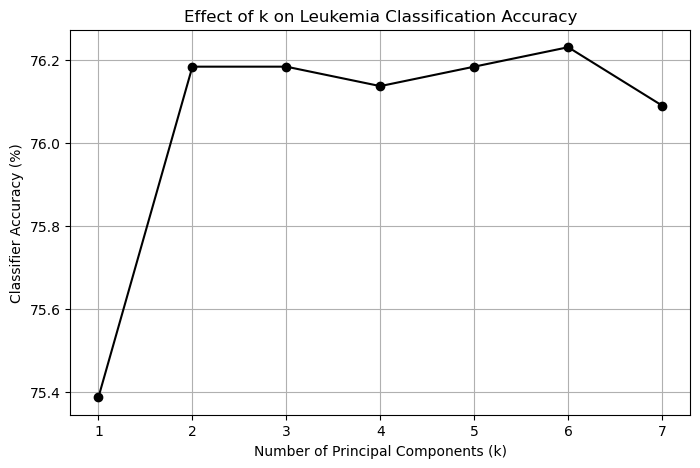

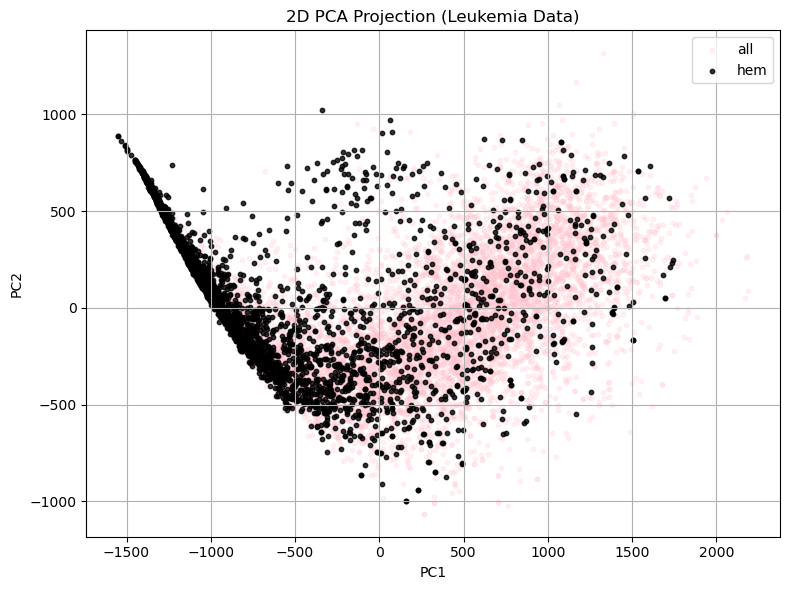

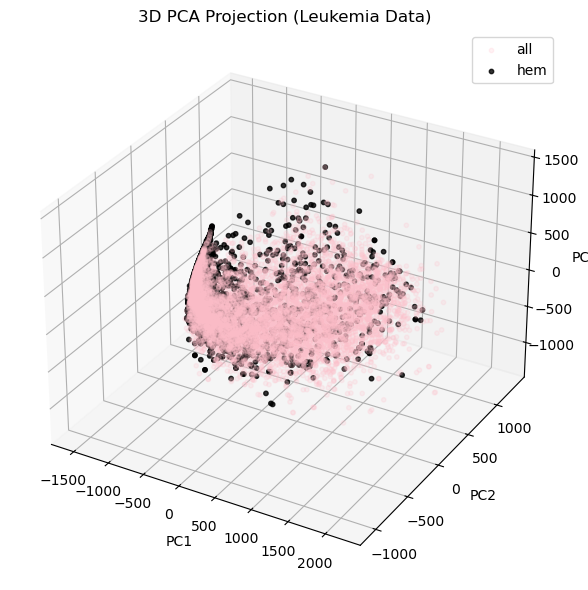

In [51]:
# Step 4: Plot k vs accuracy
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracy_results, marker='o', linestyle='-', color='black')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Classifier Accuracy (%)")
plt.title("Effect of k on Leukemia Classification Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.show()

# Step 5: 2D and 3D PCA visualization
# 2D Plot
plt.figure(figsize=(8, 6))

# Plot 'all' class (label 0)
plt.scatter(
    X_2d[y == 0, 0], X_2d[y == 0, 1],
    color='pink', alpha=0.2, s=10, label='all'
)

# Plot 'hem' class (label 1)
plt.scatter(
    X_2d[y == 1, 0], X_2d[y == 1, 1],
    color='black', alpha=0.8, s=10, label='hem'
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection (Leukemia Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot 'all' class (label 0)
idx_all = np.where(y == 0)[0]
ax.scatter(
    X_3d[idx_all, 0],
    X_3d[idx_all, 1],
    X_3d[idx_all, 2],
    color="pink",
    label="all",
    alpha=0.2,
    s=10
)

# Plot 'hem' class (label 1)
idx_hem = np.where(y == 1)[0]
ax.scatter(
    X_3d[idx_hem, 0],
    X_3d[idx_hem, 1],
    X_3d[idx_hem, 2],
    color="black",
    label="hem",
    alpha=0.8,
    s=10
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Projection (Leukemia Data)")
ax.legend()
plt.tight_layout()
plt.show()

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Load and preprocess leukemia images
def load_leukemia_images(root_path, img_size=64):
    X, y = [], []
    label_map = {}
    label_counter = 0
    for fold in sorted(os.listdir(root_path)):
        fold_path = os.path.join(root_path, fold)
        if not os.path.isdir(fold_path): continue
        for label in sorted(os.listdir(fold_path)):
            label_path = os.path.join(fold_path, label)
            if not os.path.isdir(label_path): continue
            if label not in label_map:
                label_map[label] = label_counter
                label_counter += 1
            for fname in os.listdir(label_path):
                if fname.lower().endswith(".bmp"):
                    fpath = os.path.join(label_path, fname)
                    img = cv2.imread(fpath)
                    if img is not None:
                        img = cv2.resize(img, (img_size, img_size))
                        X.append(img.flatten())
                        y.append(label_map[label])
    return np.array(X), np.array(y), label_map

# Path to data
root_path = "/Users/apple/Desktop/WAMM/Leukemia/training_data"
X, y, label_map = load_leukemia_images(root_path)
X = X / 255.0  # Normalize
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# PCA and choose k for 95% variance
pca = PCA()
pca.fit(X_train)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
k = np.argmax(explained_variance_ratio >= 0.95) + 1
print(f"Number of components for 95% variance: {k}")

# Project data using top-k components
pca_k = PCA(n_components=k)
X_train_pca = pca_k.fit_transform(X_train)
X_test_pca = pca_k.transform(X_test)

Number of components for 95% variance: 525



Ridge Test Accuracy: 0.8134
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1455
           1       0.75      0.62      0.68       678

    accuracy                           0.81      2133
   macro avg       0.79      0.76      0.77      2133
weighted avg       0.81      0.81      0.81      2133


KNN Test Accuracy: 0.8083
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.87      1455
           1       0.76      0.58      0.66       678

    accuracy                           0.81      2133
   macro avg       0.79      0.75      0.76      2133
weighted avg       0.80      0.81      0.80      2133


SVM Test Accuracy: 0.8392
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      1455
           1       0.80      0.65      0.72       678

    accuracy               

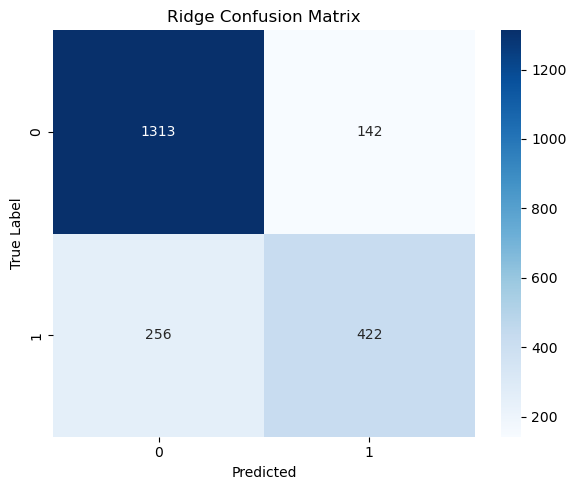

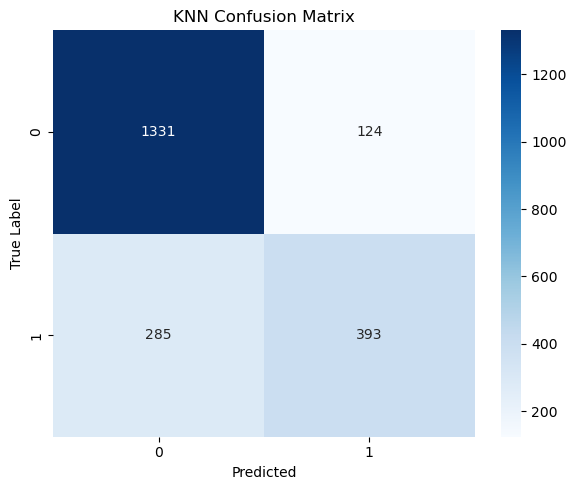

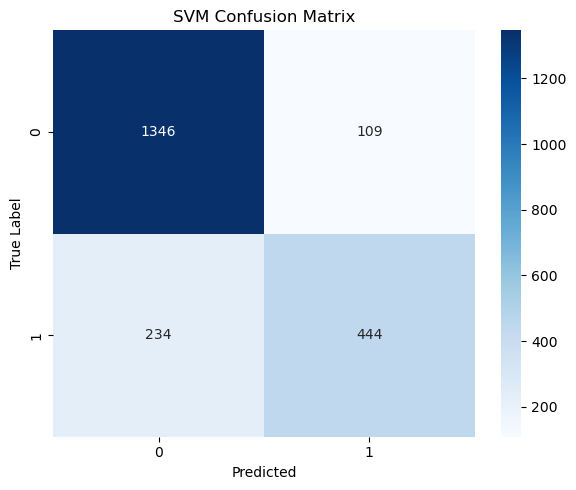

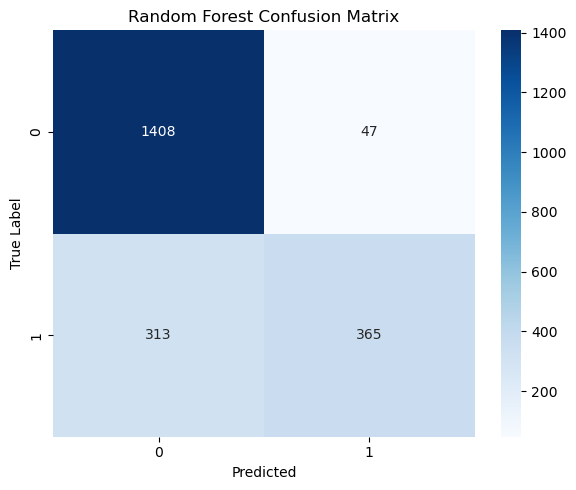

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define classifiers and parameter grids
models = {
    "Ridge": (RidgeClassifier(), {"alpha": [0.01, 0.1, 1, 10, 100]}),
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [1, 3, 5, 7, 9]}),
    "SVM": (SVC(), None),  # No grid search for SVM
    "Random Forest": (RandomForestClassifier(random_state=42), {"n_estimators": [50, 100, 200]})
}

# Train and evaluate models
results = {}

for name, (clf, param_grid) in models.items():
    if param_grid:
        grid = GridSearchCV(clf, param_grid, cv=5)
        grid.fit(X_train_pca, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = clf.fit(X_train_pca, y_train)
    
    y_pred = best_model.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    results[name] = (best_model, acc)

    print(f"\n{name} Test Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))

# Confusion Matrix Plotting
def plot_cm(model, name):
    y_pred = model.predict(X_test_pca)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for all models
for name, (model, _) in results.items():
    plot_cm(model, name)

Classification Report:
               precision    recall  f1-score   support

         all       0.87      0.94      0.90      1455
         hem       0.84      0.70      0.76       678

    accuracy                           0.86      2133
   macro avg       0.86      0.82      0.83      2133
weighted avg       0.86      0.86      0.86      2133



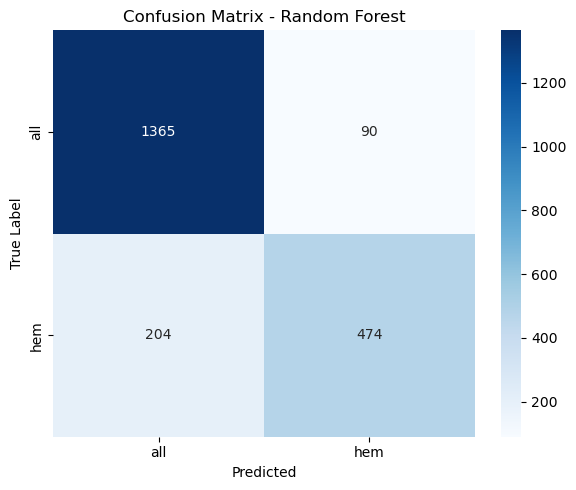

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Parameters
img_size = 64
root_path = "/Users/apple/Desktop/WAMM/Leukemia/training_data"

# Load all folds and labels (from fold_0, fold_1, fold_2)
def load_all_folds(root):
    X, y = [], []
    for fold in os.listdir(root):
        fold_path = os.path.join(root, fold)
        if not os.path.isdir(fold_path): continue  # skip .DS_Store
        for label in os.listdir(fold_path):
            label_path = os.path.join(fold_path, label)
            if not os.path.isdir(label_path): continue
            for fname in os.listdir(label_path):
                if fname.lower().endswith('.bmp'):
                    fpath = os.path.join(label_path, fname)
                    img = cv2.imread(fpath)
                    if img is not None:
                        img = cv2.resize(img, (img_size, img_size))
                        X.append(img.flatten())
                        y.append(label)
    return np.array(X), np.array(y)

# Load and encode
X, y = load_all_folds(root_path)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set
y_pred = clf.predict(X_val)

# Report
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

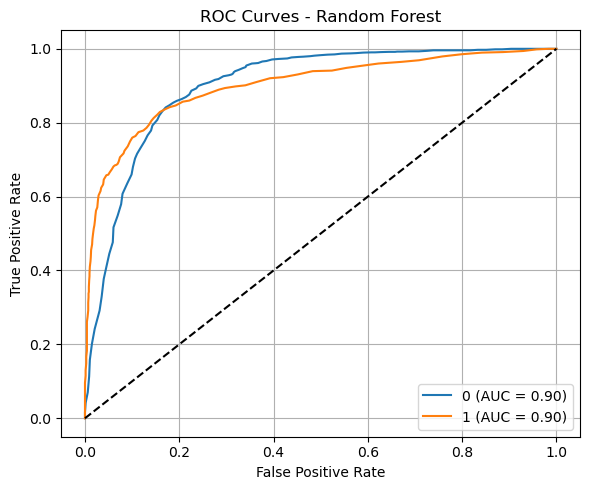

Cross-Validation Accuracy Summary:
   Fold  Accuracy  Mean Accuracy   Std Dev
0     1  0.866385       0.848136  0.031181
1     2  0.878518       0.848136  0.031181
2     3  0.872420       0.848136  0.031181
3     4  0.825047       0.848136  0.031181
4     5  0.798311       0.848136  0.031181


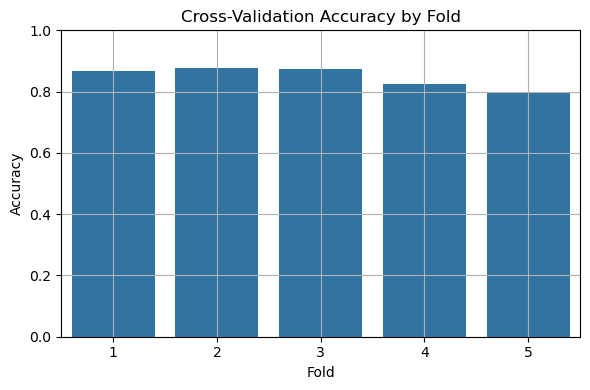

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Train the classifier before ROC evaluation
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ROC Curve
y_prob = clf.predict_proba(X_val)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_val == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
for i, label in enumerate(le.classes_):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(clf, X, y_encoded, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
cv_scores_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': cv_scores
})
cv_scores_df['Mean Accuracy'] = cv_scores.mean()
cv_scores_df['Std Dev'] = cv_scores.std()

print("Cross-Validation Accuracy Summary:")
print(cv_scores_df)

plt.figure(figsize=(6, 4))
sns.barplot(x="Fold", y="Accuracy", data=cv_scores_df)
plt.ylim(0, 1)
plt.title("Cross-Validation Accuracy by Fold")
plt.tight_layout()
plt.grid(True)
plt.show()

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

img_size = 64

# CNN-ready Dataset
class LeukemiaDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).reshape(-1, 3, img_size, img_size) / 255.0
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(LeukemiaDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(LeukemiaDataset(X_val, y_val), batch_size=32)

# CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32 * (img_size // 4) * (img_size // 4), 64), nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Epoch 1 | Train Acc: 78.42% | Val Acc: 80.59%
Epoch 2 | Train Acc: 80.16% | Val Acc: 80.87%
Epoch 3 | Train Acc: 80.36% | Val Acc: 81.11%
Epoch 4 | Train Acc: 80.71% | Val Acc: 81.48%
Epoch 5 | Train Acc: 81.74% | Val Acc: 81.86%
Epoch 6 | Train Acc: 82.07% | Val Acc: 81.90%
Epoch 7 | Train Acc: 82.83% | Val Acc: 83.68%
Epoch 8 | Train Acc: 83.62% | Val Acc: 84.01%
Epoch 9 | Train Acc: 83.79% | Val Acc: 84.15%
Epoch 10 | Train Acc: 84.79% | Val Acc: 84.34%


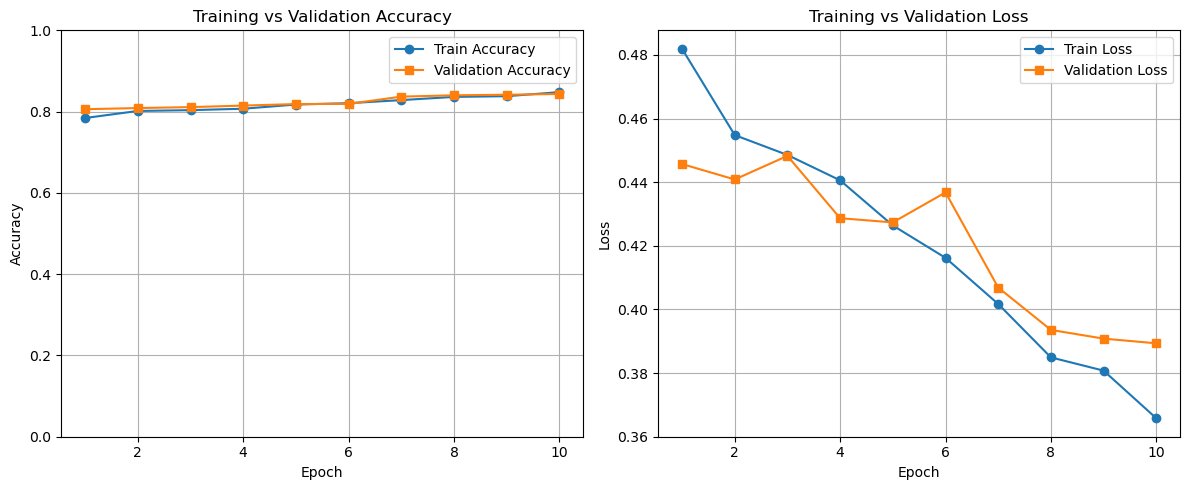

In [48]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(10):
    # Training
    model.train()
    correct_train, total_train, total_loss_train = 0, 0, 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss_train += loss.item()
        correct_train += (pred.argmax(1) == yb).sum().item()
        total_train += yb.size(0)
    train_acc = correct_train / total_train
    train_loss = total_loss_train / len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    correct_val, total_val, total_loss_val = 0, 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            loss = criterion(pred, yb)
            total_loss_val += loss.item()
            correct_val += (pred.argmax(1) == yb).sum().item()
            total_val += yb.size(0)
    val_acc = correct_val / total_val
    val_loss = total_loss_val / len(val_loader)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")

# Plot accuracy and loss
epochs = range(1, 11)
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_list, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc_list, label="Validation Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_list, label="Train Loss", marker='o')
plt.plot(epochs, val_loss_list, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


CNN Test Accuracy: 0.8073
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1455
           1       0.74      0.60      0.67       678

    accuracy                           0.81      2133
   macro avg       0.79      0.75      0.77      2133
weighted avg       0.80      0.81      0.80      2133



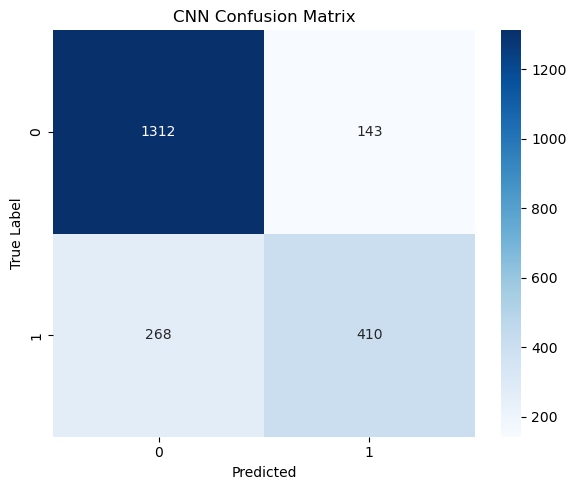

In [61]:
from sklearn.metrics import classification_report, confusion_matrix

# CNN Evaluation on Validation Set
model.eval()
y_true_cnn, y_pred_cnn = [], []

with torch.no_grad():
    for Xb, yb in val_loader:
        Xb = Xb.to(device)
        preds = model(Xb).argmax(1).cpu().numpy()
        y_pred_cnn.extend(preds)
        y_true_cnn.extend(yb.numpy())

# Accuracy and Report
cnn_acc = accuracy_score(y_true_cnn, y_pred_cnn)
print(f"\nCNN Test Accuracy: {cnn_acc:.4f}")
print("Classification Report:\n", classification_report(y_true_cnn, y_pred_cnn, target_names=le.classes_.astype(str)))

# Confusion Matrix Plot
cm = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Epoch 1 | Train Acc: 68.05% | Val Acc: 68.21%
Epoch 2 | Train Acc: 68.21% | Val Acc: 68.21%
Epoch 3 | Train Acc: 68.21% | Val Acc: 68.21%
Epoch 4 | Train Acc: 68.21% | Val Acc: 68.21%
Epoch 5 | Train Acc: 76.02% | Val Acc: 80.73%
Epoch 6 | Train Acc: 79.43% | Val Acc: 80.68%
Epoch 7 | Train Acc: 80.14% | Val Acc: 80.68%
Epoch 8 | Train Acc: 80.11% | Val Acc: 80.78%
Epoch 9 | Train Acc: 80.38% | Val Acc: 80.31%
Epoch 10 | Train Acc: 79.95% | Val Acc: 80.73%


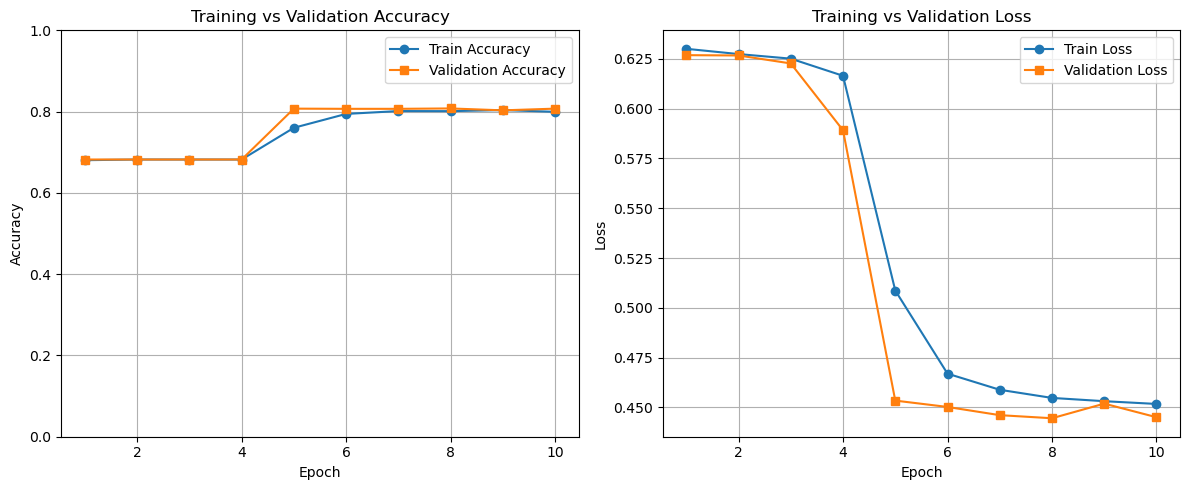

In [59]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(10):
    # Training
    model.train()
    correct_train, total_train, total_loss_train = 0, 0, 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss_train += loss.item()
        correct_train += (pred.argmax(1) == yb).sum().item()
        total_train += yb.size(0)
    train_acc = correct_train / total_train
    train_loss = total_loss_train / len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    correct_val, total_val, total_loss_val = 0, 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            loss = criterion(pred, yb)
            total_loss_val += loss.item()
            correct_val += (pred.argmax(1) == yb).sum().item()
            total_val += yb.size(0)
    val_acc = correct_val / total_val
    val_loss = total_loss_val / len(val_loader)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")

# Plot accuracy and loss
epochs = range(1, 11)
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_list, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc_list, label="Validation Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_list, label="Train Loss", marker='o')
plt.plot(epochs, val_loss_list, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()